In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
from string import punctuation

# Training Data

In [2]:
lines = [line.strip('\n') for line in open('LabelledData.txt')]
question = []
label = []
for line in lines:
    row = line.split(',,,')
    question.append(row[0].strip())
    label.append(row[1].strip())
    
train_df = pd.DataFrame({'question':question,'label':label})
train_df.head()

,label,question
0,unknown,how did serfdom develop in and then leave russ...
1,what,what films featured the character popeye doyle ?
2,unknown,how can i find a list of celebrities ' real na...
3,what,what fowl grabs the spotlight after the chines...
4,what,what is the full form of .com ?


In [3]:
train_df.shape

(1483, 2)

In [4]:
train_df['label'].value_counts()

what           609
who            402
unknown        272
affirmation    104
when            96
Name: label, dtype: int64

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

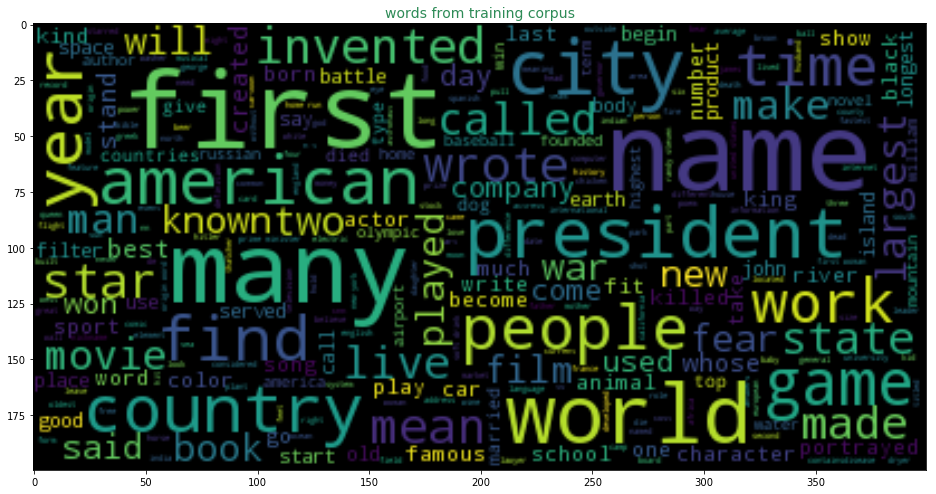

In [6]:
wc = WordCloud(background_color="black", max_words=10000,max_font_size= 50)
train_text = train_df['question'].values
wc.generate(" ".join(train_text))
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.title("words from training corpus", fontsize=14,color='seagreen')
plt.show()

In [7]:
train_df['question'].str.split(' ', expand=True).stack().value_counts()

?                  1459
the                1044
what                630
who                 421
is                  392
of                  369
in                  292
was                 234
a                   227
's                  176
to                  161
how                 130
,                   129
``                  128
''                  124
for                 121
when                106
and                 103
does                 98
are                  98
did                  98
on                   85
do                   84
first                74
name                 68
i                    65
can                  62
where                60
many                 59
it                   52
                   ... 
sun-blasted           1
sheika                1
bjorn                 1
w                     1
americas              1
bricks                1
razor                 1
automobile            1
5th                   1
airborne              1
cowardly        

In [8]:
def check_word_count(train_df,token,label):
    label_df = train_df[train_df['label']==label]
    word_df = label_df[label_df['question'].str.startswith(token)]
    print("{} questions start with '{}' out of {} labeled with '{}'".format(word_df.shape[0],token,label_df.shape[0],label))
    
def check_first_word(train_df,label,count):
    label_df = train_df[train_df['label']==label]
    count_df = label_df['question'].apply(lambda x:x.split()[0].strip()).value_counts().head(count)
    print("Most frequent first word in '{}' questions".format(label))
    print(count_df)

In [9]:
check_word_count(train_df,"what","what")
check_word_count(train_df,"when","what")
check_word_count(train_df,"who","what")
print("--------------------------------")
check_word_count(train_df,"what","when")
check_word_count(train_df,"when","when")
check_word_count(train_df,"who","when")
print("--------------------------------")
check_word_count(train_df,"what","who")
check_word_count(train_df,"when","who")
check_word_count(train_df,"who","who")
print("\n")

584 questions start with 'what' out of 609 labeled with 'what'
5 questions start with 'when' out of 609 labeled with 'what'
3 questions start with 'who' out of 609 labeled with 'what'
--------------------------------
12 questions start with 'what' out of 96 labeled with 'when'
84 questions start with 'when' out of 96 labeled with 'when'
0 questions start with 'who' out of 96 labeled with 'when'
--------------------------------
1 questions start with 'what' out of 402 labeled with 'who'
0 questions start with 'when' out of 402 labeled with 'who'
401 questions start with 'who' out of 402 labeled with 'who'




In [10]:
check_first_word(train_df,'unknown',10)
print("---------------------------")
check_first_word(train_df,'affirmation',10)

Most frequent first word in 'unknown' questions
how      125
where     56
which     23
name      18
why       17
whose     12
what       6
in         4
when       3
whom       3
Name: question, dtype: int64
---------------------------
Most frequent first word in 'affirmation' questions
does     25
can      24
is       22
will     10
do        8
are       6
could     3
would     3
which     1
has       1
Name: question, dtype: int64


# Text Cleaning

In [11]:
class Preprocessor(object):
    
    def text_preprocessing(self, doc, remove_stop_words=True, stem_words=False):
        doc = re.sub(r'\d+', '', doc.lower())
        doc = ''.join([c for c in doc if c not in punctuation])
        doc = doc.split()
        
        if remove_stop_words:
            stopwords = nltk.corpus.stopwords.words('english')
            ignore_first_words = ('what','when','who','do','does','can','is','will','how','where','which','name')
            stopwords = [s for s in stopwords if s not in ignore_first_words]
            doc = [t for t in doc if t not in set(stopwords)]
            
        if stem_words:
            stemmer = SnowballStemmer('english')
            doc = [stemmer.stem(t) for t in doc]
        
        doc = ' '.join(doc)
        return doc

In [12]:
def preprocessing(df, column):
    pre = Preprocessor()
    df['preprocessed'] = df[column].apply(lambda x: pre.text_preprocessing(x))
    return df
    
def tfidf_features(df, column='preprocessed'):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),use_idf=True,max_features=10000,binary=True)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[column]).todense()
    num_samples, num_features=tfidf_matrix.shape
    print("Number of Samples: {}, Number of Features: {}".format(num_samples, num_features))
    return tfidf_matrix

# Occurence of words after preprocessing

In [14]:
df['preprocessed'].str.split(' ', expand=True).stack().value_counts()

what           630
who            421
is             392
how            130
when           106
does            98
do              84
first           74
name            68
can             62
where           60
many            59
world           39
which           33
us              32
city            31
president       26
country         25
get             24
american        23
people          23
find            22
work            22
invented        21
wrote           19
mean            19
called          18
new             18
made            18
time            17
              ... 
log              1
bette            1
einstein         1
determine        1
harness          1
football         1
image            1
tongue           1
fertile          1
transmitted      1
airports         1
lou              1
associated       1
valley           1
snoopy           1
embedded         1
pull             1
spice            1
front            1
cage             1
shroud           1
cabinet     

# Build Model

In [13]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

In [14]:
def plot_confusion_matrix(matrix, labels, title='Confusion matrix'):
    fig, ax  = plt.subplots(figsize=(15, 10))
    ax.set_xticks([x for x in range(len(labels))])
    ax.set_yticks([y for y in range(len(labels))])
    ax.set_xticks([x + 0.5 for x in range(len(labels))], minor=True)
    ax.set_xticklabels(labels, rotation='90', fontsize=10, minor=True)
    ax.set_yticks([y + 0.5 for y in range(len(labels))], minor=True)
    ax.set_yticklabels(labels[::-1], fontsize=10, minor=True)
    ax.tick_params(which='major', labelbottom='off', labelleft='off')
    ax.tick_params(which='minor', width=0)
    proportions = [1. * row / sum(row) if sum(row) > 0 else 1. * row for row in matrix]
    ax.pcolor(np.array(proportions[::-1]), cmap=plt.cm.Blues)
    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            confusion = matrix[::-1][row][col]
            if confusion != 0:
                ax.text(col + 0.5, row + 0.5, confusion, fontsize=9,
                    horizontalalignment='center',
                    verticalalignment='center')

    ax.grid(True, linestyle=':')
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

In [17]:
class TrainModel(object):
    def __init__(self, train_df):
        self.train_df = train_df
        self.svm = LinearSVC()
        self.logistic = LogisticRegression()
        self.naive_bayes = MultinomialNB()
        self.forest = RandomForestClassifier() 

        self.eclf = VotingClassifier(estimators=[('clf1',self.svm), ('clf2',self.logistic), ('clf3',self.naive_bayes),('clf4',self.forest)], voting='hard')
        
    def do_cross_validation(self, tfidf_train):
        for clf, label in zip([self.svm,self.logistic,self.naive_bayes,self.forest,self.eclf], ['SVM','Logistic','Naive Bayes','Random Forest','Ensemble']):
            scores = cross_val_score(clf, tfidf_train, self.train_df['label'], cv=5, scoring='accuracy')
            print("Accuracy: %0.4f [%s]" % (scores.mean(), label))
    
    def generate_classification_report(self, tfidf_train):
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
        for train_index, test_index in sss.split(self.train_df["question"], self.train_df["label"]):
            X_train, Y_train = tfidf_train[train_index], train_df.loc[train_index, 'label']
            X_test, Y_test = tfidf_train[test_index], train_df.loc[test_index, 'label']
            forest = RandomForestClassifier()
            model = forest.fit(X_train,Y_train)
            Y_pred = model.predict(X_test)
            print(classification_report(y_true=Y_test, y_pred=Y_pred))
            cm = confusion_matrix(y_true=Y_test, y_pred= Y_pred)
            plot_confusion_matrix(cm,labels=sorted(train_df['label'].unique()))
    
    def build_model(self, text_column):
        self.train_df = preprocessing(self.train_df,text_column)
        
        tfidf_train = tfidf_features(self.train_df)
        self.do_cross_validation(tfidf_train)
        self.generate_classification_report(tfidf_train)
        
        

/mnt/conda_env/py/envs/py27/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:1039: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Number of Samples: 1483, Number of Features: 9247
Accuracy: 0.9244 [SVM]
Accuracy: 0.8246 [Logistic]
Accuracy: 0.7371 [Naive Bayes]
Accuracy: 0.9373 [Random Forest]


/mnt/conda_env/py/envs/py27/lib/python2.7/site-packages/sklearn/preprocessing/label.py:167: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/mnt/conda_env/py/envs/py27/lib/python2.7/site-packages/sklearn/preprocessing/label.py:167: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/mnt/conda_env/py/envs/py27/lib/python2.7/site-packages/sklearn/preprocessing/label.py:167: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/mnt/conda_env/py/envs/py27/lib/python2.7/site-packages/sklearn/preprocessing/label.py:167: DeprecationWarning: The truth value of

Accuracy: 0.8853 [Ensemble]
             precision    recall  f1-score   support

affirmation       0.87      0.95      0.91        21
    unknown       0.91      0.93      0.92        54
       what       0.97      0.98      0.98       122
       when       1.00      0.74      0.85        19
        who       0.99      0.99      0.99        81

avg / total       0.96      0.96      0.96       297



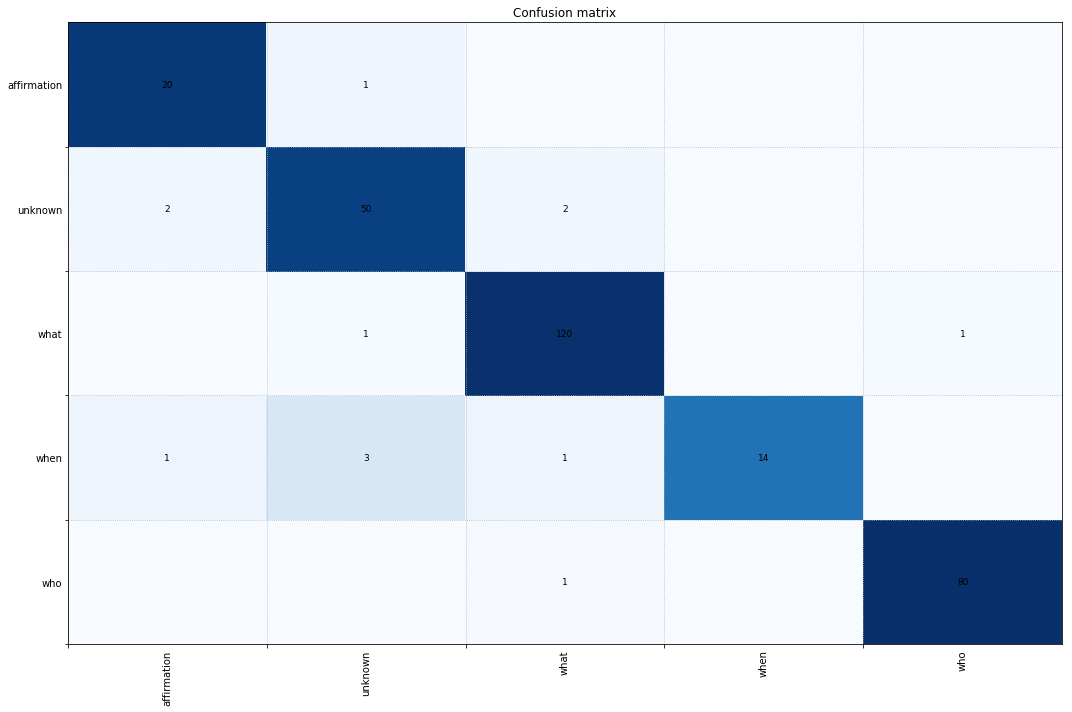

In [18]:
predict = TrainModel(train_df)
train_pre = predict.build_model('question')

# FastText Model

In [19]:
import os
from pyfasttext import FastText
current_dir = os.getcwd()
hyper_params =  {"lr":0.01,
                 "epoch":20,
                 "wordNgrams":2,
                  "dim":10}

In [20]:
def prep_train(df):
    df = preprocessing(df,'question')
    df["input"] = df.apply(lambda x: "__label__" + str(x["label"]) + " " + str(x["preprocessed"]), axis=1)
    return df

def train_models(inp_file_path, model_path,hyper_params):
    model = FastText()
    model.supervised(input=inp_file_path,
                        output=model_path,
                        **hyper_params)
    return model


def do_cross_validation_ft(df):
    training_df = prep_train(df)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    for train_index, test_index in sss.split(training_df["preprocessed"], training_df["label"]):
        X_train, Y_train = training_df.loc[train_index, 'input'], training_df.loc[train_index, 'label']
        test =   pd.DataFrame(training_df.loc[test_index, :])
        inp_file_path = current_dir + "/" + "fasttext_data.tsv"
        model_path = current_dir + "/" + "fasttext_model"
        X_train.to_csv(inp_file_path, sep="\t", index=False)
        model = train_models(inp_file_path, model_path, hyper_params)
        test["pred"] = model.predict_proba(test.preprocessed)
        test["y_pred"] = test.pred.apply(lambda x : x[0][0])
        print(classification_report(y_true=test['label'], y_pred=test['y_pred']))
        

In [21]:
do_cross_validation_ft(train_df)

             precision    recall  f1-score   support

affirmation       0.40      0.10      0.15        21
    unknown       1.00      0.09      0.17        54
       what       0.77      0.99      0.87       122
       when       0.23      0.47      0.31        19
        who       0.88      0.99      0.93        81

avg / total       0.78      0.73      0.67       297

